In [1]:
import polars as pl
import polars.selectors as cs
import pandas as pd

import plotly.express as px
import plotly.offline as pyo
import matplotlib.pyplot as plt

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
schema = {
    "id": pl.UInt32,
    "age": pl.UInt32,
    "job": pl.String,
    "marital": pl.String,
    "education": pl.String,
    "default": pl.String,
    "housing": pl.String,
    "loan": pl.String,
    "contact": pl.String,
    "month": pl.String,
    "day_of_week": pl.String,
    "duration": pl.UInt32,
    "campaign": pl.UInt32,
    "pdays": pl.UInt32,
    "previous": pl.UInt32,
    "poutcome": pl.String,
    "emp.var.rate": pl.Float32,
    "cons.price.idx": pl.Float32,
    "cons.conf.idx": pl.Float32,
    "euribor3m": pl.Float32,
    "nr.employed": pl.Float32, # start with float, cause one value is float
    "conversion": pl.String, #change y to conversion for better understanding
    "test_control_flag": pl.String
    
}

In [3]:
data = pl.read_csv("data/bank_data_prediction_task_2024.csv", schema=schema, null_values=["NA"])

# change datatypes


In [4]:
#turn nr.employed to int
data = data.with_columns(pl.col("nr.employed").cast(pl.Int32))

In [5]:
#turn y to 0 and 1
data = data.with_columns(pl.col("conversion").replace({'no': 0, 'yes': 1}).cast(pl.UInt32))

In [6]:
data = data.with_columns(
    pl.col("test_control_flag")
    .replace({'campaign group': 1, 'control group': 0}).cast(pl.UInt32)
    ).rename({"test_control_flag": "in_campaign_group"}
)

In [7]:
data.describe()

statistic,id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,conversion,in_campaign_group
str,f64,f64,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64
"""count""",41188.0,41188.0,"""41188""","""41188""","""41188""","""41188""","""41188""","""41188""","""16476""","""16476""","""16476""",16476.0,16476.0,41188.0,41188.0,"""41188""",41188.0,40938.0,41188.0,41188.0,41188.0,41188.0,41188.0
"""null_count""",0.0,0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""24712""","""24712""","""24712""",24712.0,24712.0,0.0,0.0,"""0""",0.0,250.0,0.0,0.0,0.0,0.0,0.0
"""mean""",20594.5,40.02406,null,null,null,null,null,null,null,null,null,259.660172,2.546856,962.475454,0.172963,null,0.081886,93.575951,-40.502602,3.621291,5166.849446,0.125473,0.400019
"""std""",11890.09578,10.42125,null,null,null,null,null,null,null,null,null,260.660561,2.699664,186.910907,0.494901,null,1.57096,0.57889,4.628198,1.734447,72.328375,0.331259,0.489908
"""min""",1.0,17.0,"""admin.""","""divorced""","""basic.4y""","""no""","""no""","""no""","""cellular""","""apr""","""fri""",0.0,1.0,0.0,0.0,"""failure""",-3.4,92.200996,-50.799999,0.634,4963.0,0.0,0.0
"""25%""",10298.0,32.0,null,null,null,null,null,null,null,null,null,103.0,1.0,999.0,0.0,null,-1.8,93.074997,-42.700001,1.344,5099.0,0.0,0.0
"""50%""",20595.0,38.0,null,null,null,null,null,null,null,null,null,180.0,2.0,999.0,0.0,null,1.1,93.749001,-41.799999,4.857,5191.0,0.0,0.0
"""75%""",30891.0,47.0,null,null,null,null,null,null,null,null,null,321.0,3.0,999.0,0.0,null,1.4,93.994003,-36.400002,4.961,5228.0,0.0,1.0
"""max""",41188.0,98.0,"""unknown""","""unknown""","""unknown""","""yes""","""yes""","""yes""","""telephone""","""sep""","""wed""",4918.0,43.0,999.0,7.0,"""success""",1.4,94.766998,-26.9,5.045,5228.0,1.0,1.0


# Missing values

we have two places of missing values:
1) for control group all of contact, month, day_of_week, campaign, duration are empty
2) for consumer price index there are 250 missing values. 

In [8]:
#we can see that the observations are rather sorted, hence we can fill the null values with forward fill
data = data.with_columns(pl.col("cons.price.idx").forward_fill())

## Data exploration

### Expectations:
- H1: data is unbalanced - number of not subscribed observations will be much higher
- H2: Mostly elderly people subscribe to the product
- H3: People with loans (housing or loan) or with payment issues (default) are less likely to subscribe
- H4: Social and economic indicators have low impact on the outcome variable

### Dataset balance

In [9]:
# find balance of the dataset:
counts = data.group_by(["in_campaign_group", "conversion"]).agg(pl.count("conversion").alias("count"))
fig = px.bar(counts, y='count', x="conversion", color="in_campaign_group")
pyo.iplot(fig)

Only 5168 people subscribed to the product, while over 36 000 did not. It is a clear indicator off unbalanced dataset

### Age distribution

the data is heavily unbalanced, indicating that the conversion rate of people who decide to subscribe to product is low.

In [10]:
# plot the age distribution for outcome variable (product subscription) distinguishing between the control and campaign group
fig = px.violin(data, y='age', x='conversion', color='in_campaign_group', box=True, points='all', title='Age Distribution by conversion and in_campaign_group')
pyo.iplot(fig)

- We can see that all distribusions for age are higlhy right skewed, indicating that most of observations where conducted on age group under 40 years old. 
- The group who decided to subscribe to product has a thincker tail, but it is not an indicator that edlerly people are more likely to subscribe, as the distributions are simmilar to those who did not decide to subscribe
- the median age for not subscribers is 38 years old, while for subscribers it is 37

### Other categorical variables

In [11]:
def plot_categorical(data, column):
    grouped_data = data.group_by(column, "in_campaign_group", "conversion").agg(
                pl.len().alias("count")
            ).sort(['count'], descending=True)
    fig = px.bar(grouped_data, x=column, y='count', 
             barmode='stack',
             color='in_campaign_group',
             facet_col='conversion'
            )
    pyo.iplot(fig)

In [12]:
plot_categorical(data, "job")
plot_categorical(data, "marital")
plot_categorical(data, "education")

- the majority of jobs are within admin., blue collar and technician
- the majority of people are married
- the majority of people have university degree or a high school education

- the proportions between those in control and campaign group who chose to subscribe to product is similar for all categories
    - with execptions of blue collar and technician, where more people subscribed when contacted
    - number of retired people who subscribed is proportionaly higher than we would expect if the subscribed part followed the same distribution as not subscribed
    - people with lower education when in campaign group are more likely to subscribe (more contacted people than not contacted between high.school to basic)

### Loans

In [13]:
plot_categorical(data, "housing")
plot_categorical(data, "loan")
plot_categorical(data, "default")

- People with housing loans are proportionaly less likely to subscribe
- There is not real difference between subscription and no subscription for people with loans
- Default column bring almost no value as there is only 1 default observation

### Social and economic indicators

calculate point biseral correlation to efffectively measure relation between continous and outcome binary variable

In [14]:
continuous_vars = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
correlations = {}
for var in continuous_vars:
    r_pb, p_value = stats.pointbiserialr(data['conversion'].to_numpy(), data[var].to_numpy())
    correlations[var] = {'Point-Biserial Correlation': r_pb, 'p-value': p_value}

variables = list(correlations.keys())
correlation_values = [correlations[var]['Point-Biserial Correlation'] for var in variables]
p_values = [correlations[var]['p-value'] for var in variables]
corr_df = pl.DataFrame({
    'Variable': variables,
    'Point-Biserial Correlation': correlation_values,
    'p-value': p_values
})

fig = px.bar(corr_df, x='Variable', y='Point-Biserial Correlation')
pyo.iplot(fig)

- negative `employment variation rate` correlation indicates an inverse relationship between `emp.var.rate` and binary outcome variable `y`
    - the magnitude being 0.25 means a moderate correlation, not very strong but significant
- negative `consumer price index` correlation indicates an inverse relationship between `cons.price.idx` and binary outcome variable `y`
    - the magnitude being 0.11 means a low correlation, but a significant one
- positive `consumer confidence index` correlation indicates a positive relationship between `cons.conf.idx` and binary outcome variable `y`
    - low significant
- negative `euribor 3 month rate` correlation indicates an inverse relationship between `euribor3m` and binary outcome variable `y`
    - the magnitude being 0.26 means a moderate correlation, not very strong but significant
- negative `number of employees` correlation indicates an inverse relationship between `nr.employed` and binary outcome variable `y`
    - the magnitude being 0.3 means a moderate correlation, not very strong but significant

### Contact related features

In [15]:
data_numeric = data.with_columns(pl.col("month")
            .replace({
                "jan": 1,
                "feb": 2,
                "mar": 3,
                "apr": 4,
                "may": 5,
                "jun": 6,
                "jul": 7,
                "aug": 8,
                "sep": 9,
                "oct": 10,
                "nov": 11,
                "dec": 12
            }).cast(pl.UInt32)
        )

data_numeric = data_numeric.with_columns(pl.col("day_of_week")
            .replace({
                "mon": 1,
                "tue": 2,
                "wed": 3,
                "thu": 4,
                "fri": 5
            }).cast(pl.UInt32)
        )

In [16]:
filtered_data = data_numeric.filter(pl.col("in_campaign_group") == 1)
def plot_contact_categorical(data, column):
    grouped_data = data.group_by(column, "conversion").agg(
        pl.len().alias("count")
    ).sort(['count'], descending=True)

    total_counts = grouped_data.group_by(column).agg(
        pl.sum("count")
        .alias("total_count"))
    
    grouped_data = grouped_data.join(total_counts, on=column)
    grouped_data = grouped_data.with_columns(
        (pl.col("count") / pl.col("total_count")).alias("proportion")
    )

    fig = px.bar(grouped_data, x=column, y='count', 
                 barmode='stack',
                 color='conversion',
                 title=column,
                 text='proportion')
    fig.update_traces(texttemplate='%{text:.2f}', textposition='inside')
    pyo.iplot(fig)

In [17]:
plot_contact_categorical(filtered_data, "contact")
plot_contact_categorical(filtered_data, "month")
plot_contact_categorical(filtered_data, "day_of_week")

- the cellular contact method seem to yield more subscriptions compare to telephone (17% of all cellular contacts resulted in subscription, while only 10% of telephone were succesful)
- there is a huge difference between the observetions within months, as well as the proportions between succesful outcome and total number of contacted people
- day of week proportion doesnt change across the week

the `duration` and `campaign` although may be usefull in predicting subscriptions, we cant assign them in the control group hence we can just drop them. we can also drop the `day_of_week` as it wouldnt bring any value to the model

In [18]:
data = data.drop(["duration", "campaign", "day_of_week"])

In [19]:
# fill missing values in month with "not_contacted"
# fill missing values in contacted with "not_contacted"

data = data.with_columns(
    pl.col("month").fill_null("not_contacted"),
    pl.col("contact").fill_null("not_contacted")
)


In [20]:
data = data.with_columns(
    pl.col("job").cast(pl.Categorical),
    pl.col("marital").cast(pl.Categorical),
    pl.col("education").cast(pl.Categorical),
    pl.col("default").cast(pl.Categorical),
    pl.col("housing").cast(pl.Categorical),
    pl.col("loan").cast(pl.Categorical),
    pl.col("contact").cast(pl.Categorical),
    pl.col("month").cast(pl.Categorical),
    pl.col("poutcome").cast(pl.Categorical),
)

In [21]:
#scale the continous data to range [0, 1]
cols_to_scale = [
    "age", "pdays", "previous", "emp.var.rate", 
    "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"
]

def min_max_scale(series: pl.Series) -> pl.Series:
    min_val = series.min()
    max_val = series.max()
    return (series - min_val) / (max_val - min_val)

for col in cols_to_scale:
    data = data.with_columns(min_max_scale(data[col]).alias(col))

In [22]:
data.describe()

statistic,id,age,job,marital,education,default,housing,loan,contact,month,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,conversion,in_campaign_group
str,f64,f64,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64
"""count""",41188.0,41188.0,"""41188""","""41188""","""41188""","""41188""","""41188""","""41188""","""41188""","""41188""",41188.0,41188.0,"""41188""",41188.0,41188.0,41188.0,41188.0,41188.0,41188.0,41188.0
"""null_count""",0.0,0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",20594.5,0.284248,null,null,null,null,null,null,null,null,0.963439,0.024709,null,0.725393,0.535723,0.430853,0.677237,0.769243,0.125473,0.400019
"""std""",11890.09578,0.128657,null,null,null,null,null,null,null,null,0.187098,0.0707,null,0.327283,0.225581,0.193648,0.39321,0.272937,0.331259,0.489908
"""min""",1.0,0.0,null,null,null,null,null,null,null,null,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",10298.0,0.185185,null,null,null,null,null,null,null,null,1.0,0.0,null,0.333333,0.340608,0.338912,0.160961,0.513208,0.0,0.0
"""50%""",20595.0,0.259259,null,null,null,null,null,null,null,null,1.0,0.0,null,0.9375,0.603275,0.376569,0.957379,0.860377,0.0,0.0
"""75%""",30891.0,0.37037,null,null,null,null,null,null,null,null,1.0,0.0,null,1.0,0.698755,0.60251,0.980957,1.0,0.0,1.0
"""max""",41188.0,1.0,null,null,null,null,null,null,null,null,1.0,1.0,null,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Uplift modeling

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score
from sklift.models import SoloModel, TwoModels
from sklift.viz import plot_uplift_curve, plot_qini_curve
from causalml.inference.meta import BaseXRegressor

import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import numpy as np

## Models

In [24]:
models = {
    'Logit': LogisticRegression(random_state=42),
    'XGB': xgb.XGBClassifier(objective='binary:logistic', random_state=42),
    'CatBoost': cb.CatBoostClassifier(verbose=0, random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, kernel="rbf" ,random_state=42)
}

### Metrics

In [25]:
# we have to turn data into pandas dataframe as SoloModel and TwoModels dont support polars dataframes
# turn category to dummies for better model performance
data = data.to_dummies(columns=cs.categorical()).to_pandas()

X = data.drop(["id","conversion", "in_campaign_group"], axis=1)
treatment = data["in_campaign_group"]
y = data["conversion"]

In [26]:
results_df = pd.DataFrame()

In [27]:
def get_uplift_metrics(y_test, uplift, treatment_test):
    uplift_k_values = {}
    uplift_k_all_values = {}
    
    for k in [0.1, 0.2, 0.3, 0.4, 0.5]:
        uplift_k = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treatment_test, strategy='by_group', k=k)
        uplift_k_all = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treatment_test, strategy='overall', k=k)
        
        uplift_k_values[f'uplift@{int(k*100)}'] = uplift_k
        uplift_k_all_values[f'uplift@{int(k*100)}_all'] = uplift_k_all
        
        print(f'uplift at top {int(k*100)}% by group: {uplift_k:.3f}, and overall {uplift_k_all:.3f}')
    
    uplift_auc = uplift_auc_score(y_true=y_test, uplift=uplift, treatment=treatment_test)
    uplift_qini = qini_auc_score(y_true=y_test, uplift=uplift, treatment=treatment_test)
    
    print(f'AUUC: {uplift_auc:.3f}')
    print(f'qini: {uplift_qini:.3f}')
    print("------------------------------------------------")
    
    return {**uplift_k_values, **uplift_k_all_values, 'AUUC': uplift_auc, 'qini': uplift_qini}



In [ ]:
def plot_uplift_results(y_test, uplift_sm, treatment_test, model_name, ax1, ax2, i):
    # Plot Uplift Curve
    uplift_disp = plot_uplift_curve(
        y_test, uplift_sm, treatment_test,
        perfect=True, random=True, ax=ax1
    )
    ax1.set_title(f"cv fold.{i}, {model_name} Uplift curve", fontsize=10)
    ax1.set_xlabel("Proportion Targeted", fontsize=8, color='black')
    ax1.set_ylabel("Uplift", fontsize=8, color='black')
    ax1.tick_params(axis='both', which='major', labelsize=6)

    # Plot Qini Curve
    qini_disp = plot_qini_curve(
        y_test, uplift_sm, treatment_test,
        perfect=True, random=True, ax=ax2
    )
    ax2.set_title(f"cv fold.{i}, {model_name} Qini curve", fontsize=10)
    ax2.set_xlabel("Proportion Targeted", fontsize=8, color='black')
    ax2.set_ylabel("Qini", fontsize=8, color='black')
    ax2.tick_params(axis='both', which='major', labelsize=6)

### S-Learner model

In [29]:
def cross_validate_uplift_slearner(model, X, y, treatment, model_name, cv=10):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    metrics = {
        'uplift@10': [], 'uplift@20': [], 'uplift@30': [], 'uplift@40': [], 'uplift@50': [],
        'uplift@10_all': [], 'uplift@20_all': [], 'uplift@30_all': [], 'uplift@40_all': [], 'uplift@50_all': [],
        'AUUC': [], 'qini': []
    }

    fig, axes = plt.subplots(nrows=cv, ncols=2, figsize=(14, 8))
    axes = np.atleast_2d(axes)

    for i, (train_idx, test_idx) in enumerate(skf.split(X, treatment)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        treatment_train, treatment_test = treatment.iloc[train_idx], treatment.iloc[test_idx]
        
        model.fit(X=X_train, y=y_train, treatment=treatment_train, estimator_fit_params={})
        uplift = model.predict(X_test)
        
        fold_metrics = get_uplift_metrics(y_test, uplift, treatment_test)
        plot_uplift_results(y_test, uplift, treatment_test=treatment_test, model_name=model_name, ax1=axes[i, 0], ax2=axes[i, 1], i=i)
        
        for k in [10, 20, 30, 40, 50]:
            metrics[f'uplift@{k}'].append(fold_metrics[f'uplift@{k}'])
            metrics[f'uplift@{k}_all'].append(fold_metrics[f'uplift@{k}_all'])
        
        metrics['AUUC'].append(fold_metrics['AUUC'])
        metrics['qini'].append(fold_metrics['qini'])
    
    plt.tight_layout()
    plt.show()
    
    mean_metrics = {key: np.mean(value) for key, value in metrics.items()}
    std_metrics = {key: np.std(value) for key, value in metrics.items()}
    
    return mean_metrics, std_metrics

In [30]:
def run_slearner_models_and_get_metrics(models, X, y, treatment, cv=10):
    results = []
    
    for model_name, model in models.items():
        sm = SoloModel(estimator=model)
        print("--------------------------------------------------------------------")
        print(f'Running model: {model_name}')
        mean_metrics, std_metrics = cross_validate_uplift_slearner(sm, X, y, treatment, cv=cv, model_name=model_name)

        print("--------------------------------------------------------------------")
        print(f"Cross-validated S-Learner {model_name} Uplift Metrics (Mean):")
        for key, value in mean_metrics.items():
            print(f"{key}: {value:.3f}")
        
        mean_metrics['model_name'] = "s_learner_" + model_name
        results.append(mean_metrics)
    
    df = pd.DataFrame(results)
    df = df.set_index('model_name')
    
    return df

--------------------------------------------------------------------
Running model: Logit
uplift at top 10% by group: -0.033, and overall -0.039
uplift at top 20% by group: 0.030, and overall -0.011
uplift at top 30% by group: 0.052, and overall -0.003
uplift at top 40% by group: 0.061, and overall -0.001
uplift at top 50% by group: 0.067, and overall 0.009
AUUC: -0.045
qini: 3.717
------------------------------------------------
uplift at top 10% by group: -0.091, and overall -0.096
uplift at top 20% by group: -0.016, and overall -0.067
uplift at top 30% by group: -0.004, and overall -0.038
uplift at top 40% by group: 0.021, and overall -0.027
uplift at top 50% by group: 0.033, and overall -0.020
AUUC: -0.068
qini: 9.020
------------------------------------------------


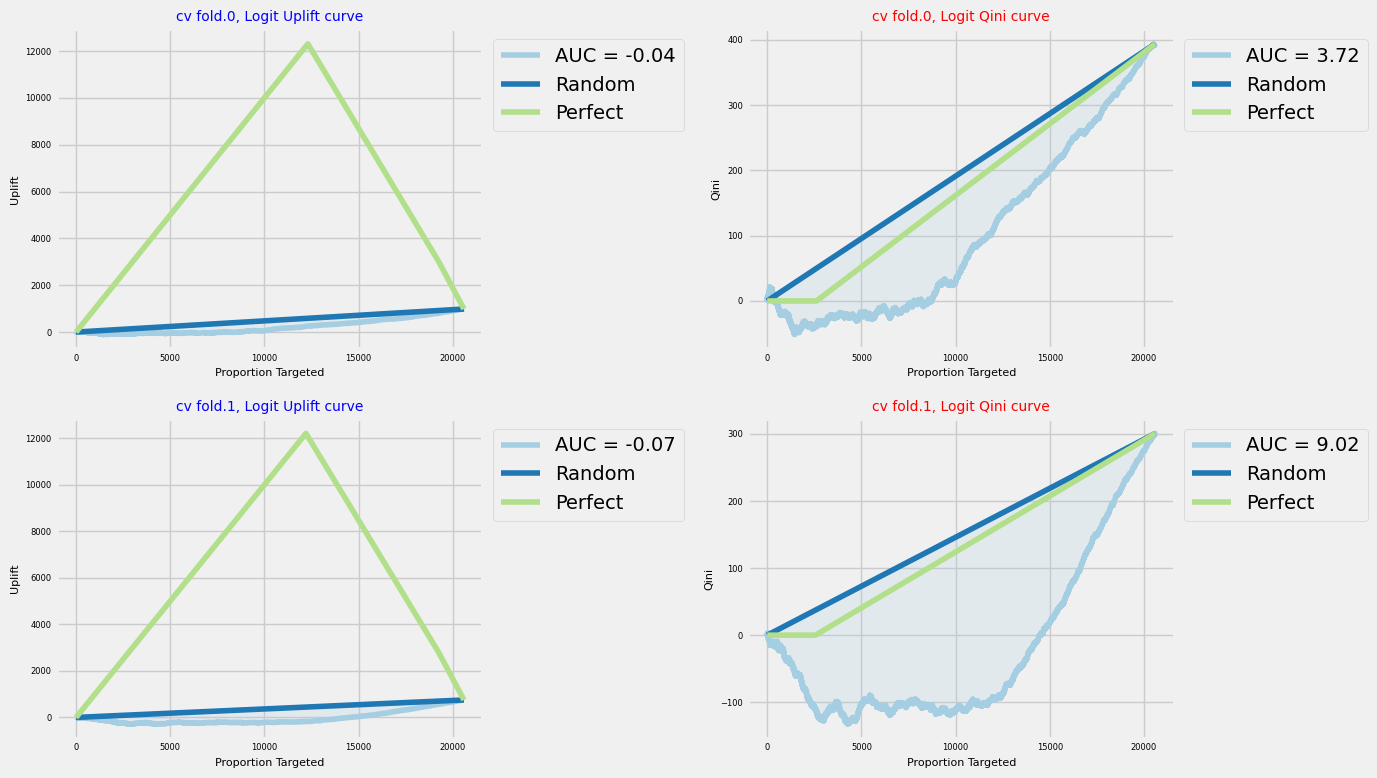

--------------------------------------------------------------------
Cross-validated S-Learner Logit Uplift Metrics (Mean):
uplift@10: -0.062
uplift@20: 0.007
uplift@30: 0.024
uplift@40: 0.041
uplift@50: 0.050
uplift@10_all: -0.067
uplift@20_all: -0.039
uplift@30_all: -0.020
uplift@40_all: -0.014
uplift@50_all: -0.006
AUUC: -0.056
qini: 6.369
--------------------------------------------------------------------
Running model: XGB
uplift at top 10% by group: 0.014, and overall nan
uplift at top 20% by group: 0.048, and overall nan
uplift at top 30% by group: 0.046, and overall nan
uplift at top 40% by group: 0.051, and overall nan
uplift at top 50% by group: 0.047, and overall nan
AUUC: 0.000
qini: -0.000
------------------------------------------------
uplift at top 10% by group: -0.052, and overall nan
uplift at top 20% by group: -0.032, and overall nan
uplift at top 30% by group: -0.007, and overall nan
uplift at top 40% by group: 0.001, and overall nan
uplift at top 50% by group: 0.0

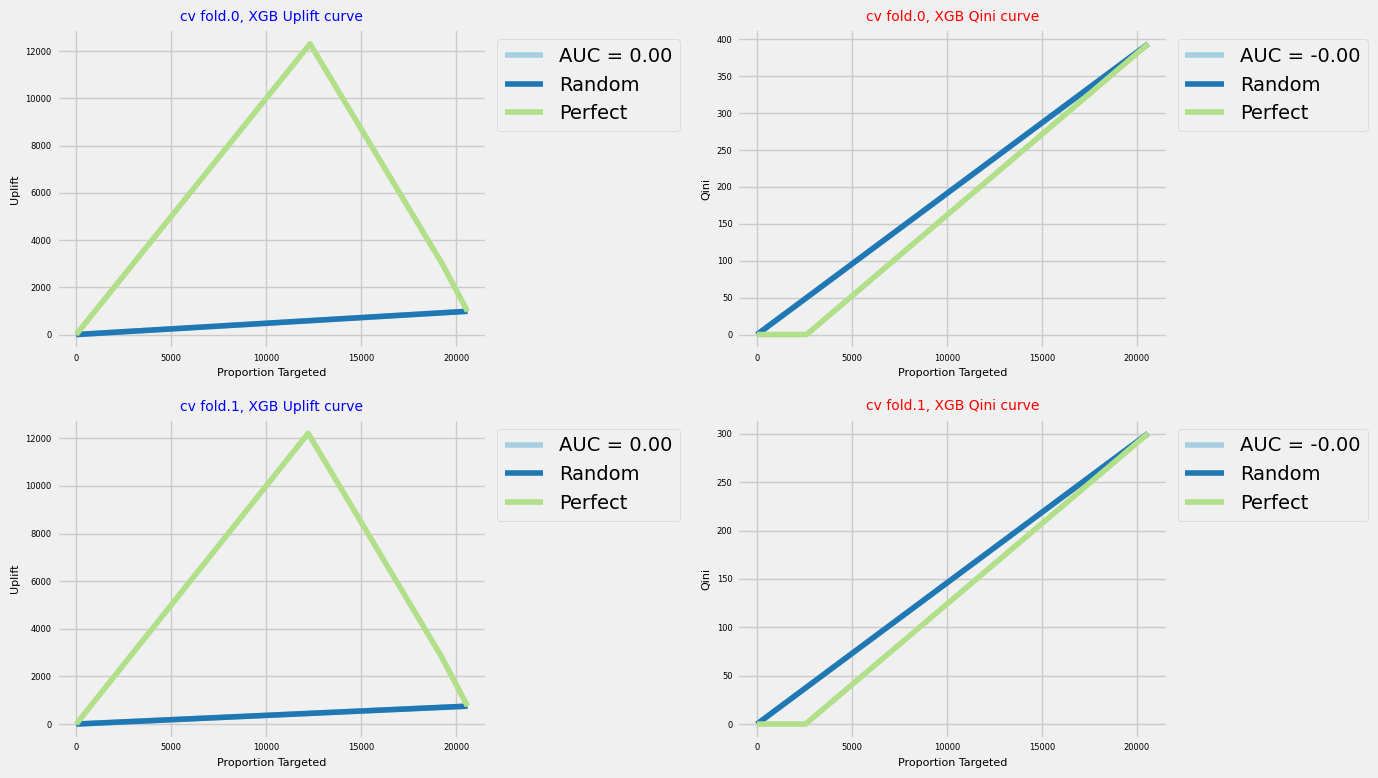

--------------------------------------------------------------------
Cross-validated S-Learner XGB Uplift Metrics (Mean):
uplift@10: -0.019
uplift@20: 0.008
uplift@30: 0.020
uplift@40: 0.026
uplift@50: 0.029
uplift@10_all: nan
uplift@20_all: nan
uplift@30_all: nan
uplift@40_all: nan
uplift@50_all: nan
AUUC: 0.000
qini: 0.000
--------------------------------------------------------------------
Running model: CatBoost
uplift at top 10% by group: 0.110, and overall 0.015
uplift at top 20% by group: 0.106, and overall 0.071
uplift at top 30% by group: 0.103, and overall 0.077
uplift at top 40% by group: 0.097, and overall 0.081
uplift at top 50% by group: 0.091, and overall 0.079
AUUC: 0.038
qini: -4.941
------------------------------------------------
uplift at top 10% by group: 0.015, and overall -0.101
uplift at top 20% by group: 0.048, and overall -0.010
uplift at top 30% by group: 0.062, and overall 0.019
uplift at top 40% by group: 0.066, and overall 0.041
uplift at top 50% by group:

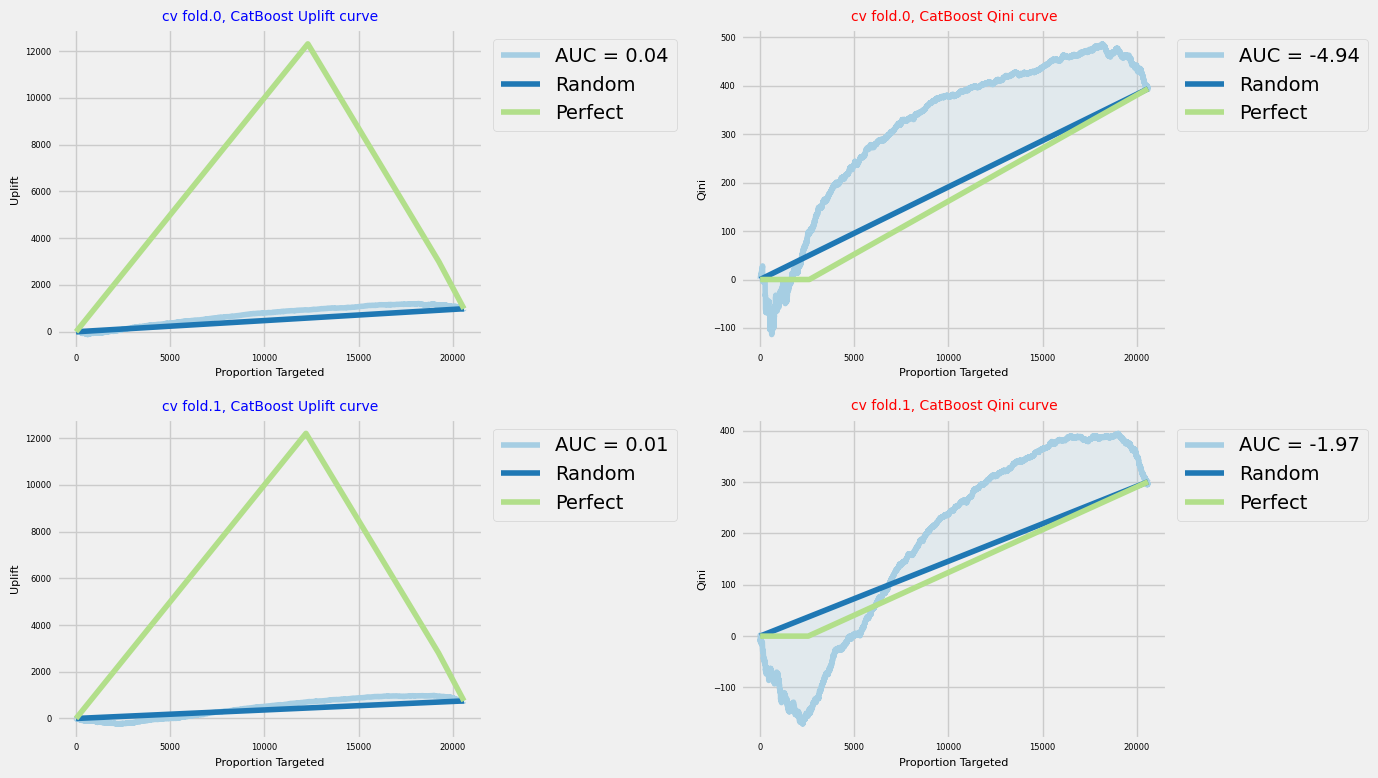

--------------------------------------------------------------------
Cross-validated S-Learner CatBoost Uplift Metrics (Mean):
uplift@10: 0.062
uplift@20: 0.077
uplift@30: 0.083
uplift@40: 0.082
uplift@50: 0.079
uplift@10_all: -0.043
uplift@20_all: 0.030
uplift@30_all: 0.048
uplift@40_all: 0.061
uplift@50_all: 0.066
AUUC: 0.026
qini: -3.457
--------------------------------------------------------------------
Running model: LightGBM
[LightGBM] [Info] Number of positive: 2554, number of negative: 18040
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 20594, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124017 -> initscore=-1.954931
[LightGBM] [Info] Start training from score -1.954931
uplift a

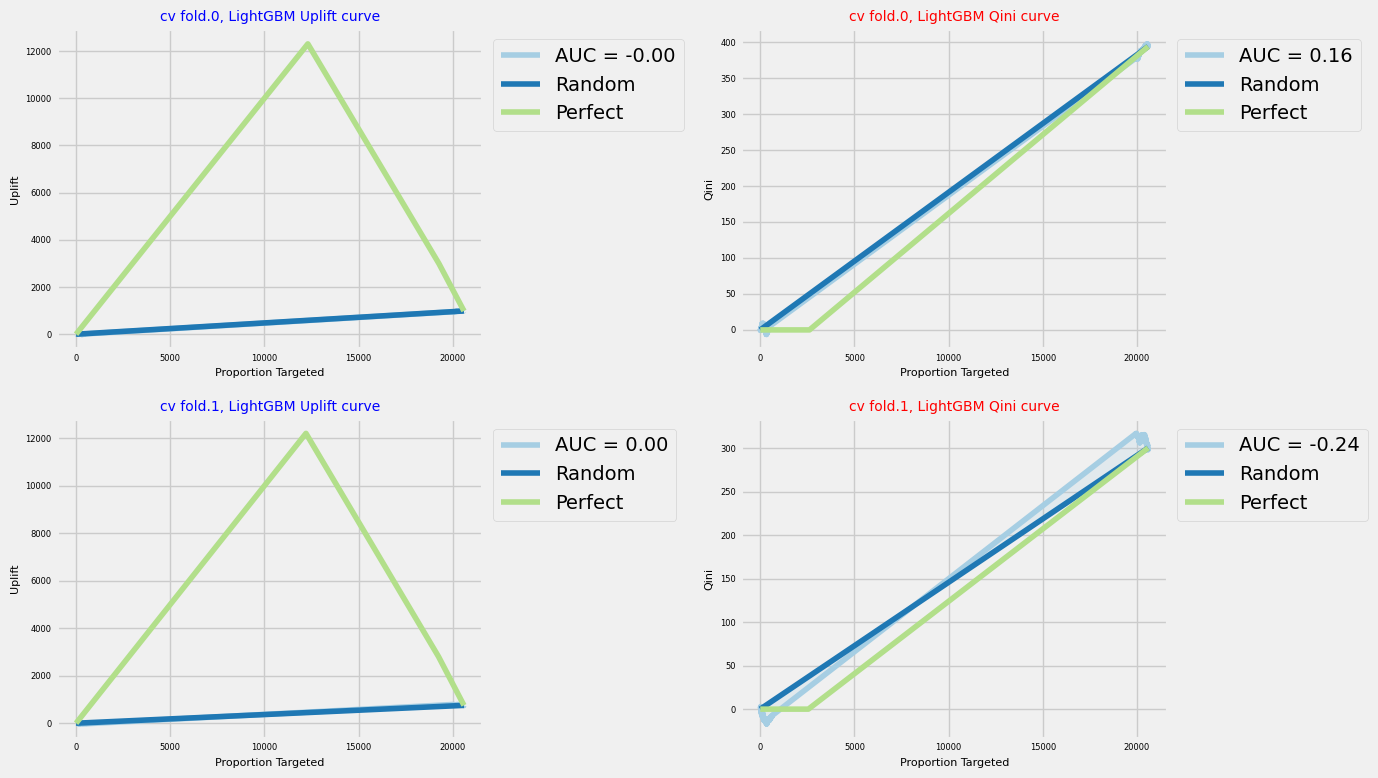

--------------------------------------------------------------------
Cross-validated S-Learner LightGBM Uplift Metrics (Mean):
uplift@10: -0.016
uplift@20: 0.010
uplift@30: 0.019
uplift@40: 0.026
uplift@50: 0.031
uplift@10_all: -0.166
uplift@20_all: -0.037
uplift@30_all: 0.023
uplift@40_all: 0.049
uplift@50_all: 0.070
AUUC: -0.000
qini: -0.038
--------------------------------------------------------------------
Running model: DecisionTree
uplift at top 10% by group: 0.049, and overall 0.054
uplift at top 20% by group: 0.029, and overall -0.107
uplift at top 30% by group: 0.053, and overall -0.061
uplift at top 40% by group: 0.048, and overall -0.023
uplift at top 50% by group: 0.050, and overall -0.002
AUUC: 0.004
qini: -0.380
------------------------------------------------
uplift at top 10% by group: -0.048, and overall -0.129
uplift at top 20% by group: -0.029, and overall -0.011
uplift at top 30% by group: -0.007, and overall 0.052
uplift at top 40% by group: 0.001, and overall 0.0

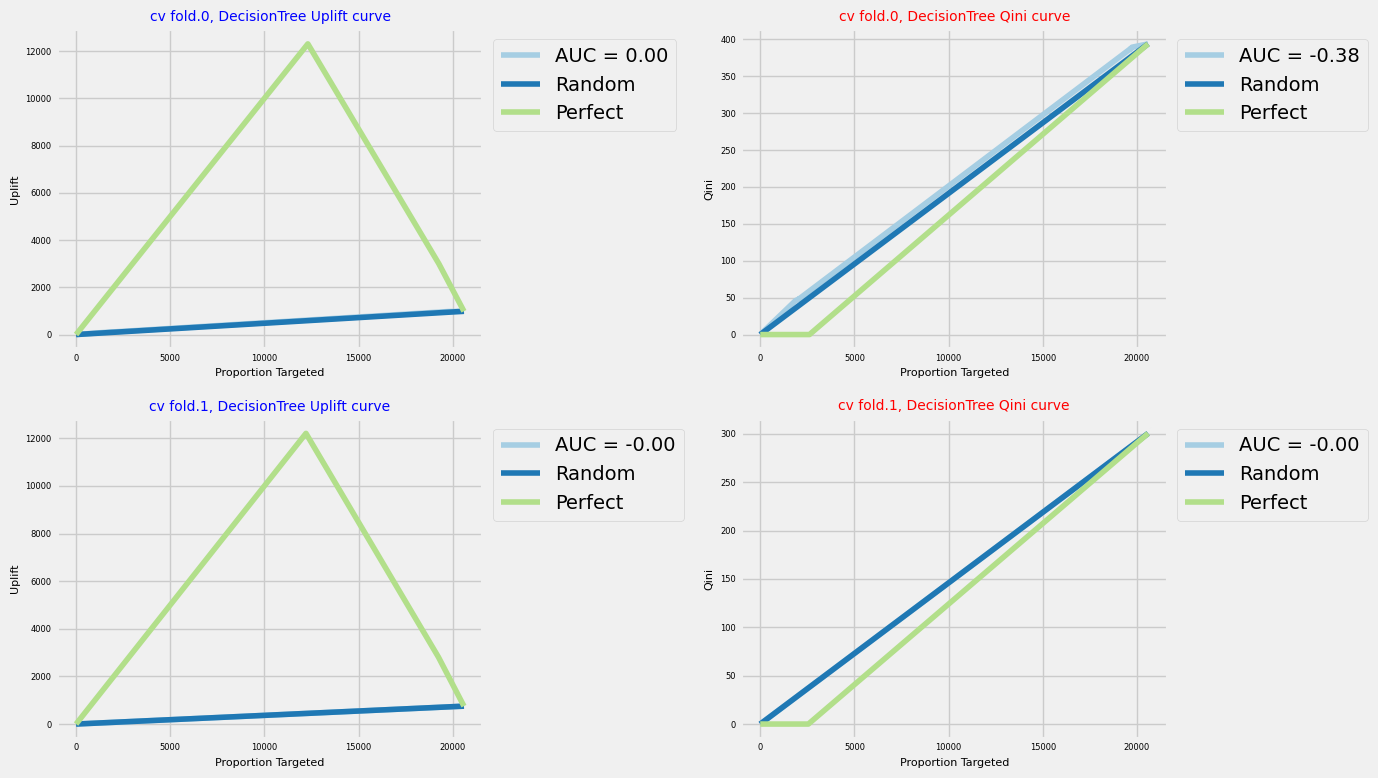

--------------------------------------------------------------------
Cross-validated S-Learner DecisionTree Uplift Metrics (Mean):
uplift@10: 0.000
uplift@20: -0.000
uplift@30: 0.023
uplift@40: 0.025
uplift@50: 0.031
uplift@10_all: -0.037
uplift@20_all: -0.059
uplift@30_all: -0.004
uplift@40_all: 0.028
uplift@50_all: 0.050
AUUC: 0.002
qini: -0.191
--------------------------------------------------------------------
Running model: SVM


In [ ]:
results_s = run_slearner_models_and_get_metrics(models, X, y, treatment, cv=2)
results_df = pd.concat([results_df, results_s])

## T-Learner - vanila

In [ ]:
def cross_validate_uplift_tlearner(model, X, y, treatment, model_name, cv=5): #different models have different parameters in fit function
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    metrics = {
        'uplift@10': [], 'uplift@20': [], 'uplift@30': [], 'uplift@40': [], 'uplift@50': [],
        'uplift@10_all': [], 'uplift@20_all': [], 'uplift@30_all': [], 'uplift@40_all': [], 'uplift@50_all': [],
        'AUUC': [], 'qini': []
    }

    fig, axes = plt.subplots(nrows=cv, ncols=2, figsize=(14, 8))
    axes = np.atleast_2d(axes)
    
    for i, (train_idx, test_idx) in enumerate(skf.split(X, treatment)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        treatment_train, treatment_test = treatment.iloc[train_idx], treatment.iloc[test_idx]
        
        model.fit(X=X_train, y=y_train, treatment=treatment_train, estimator_trmnt_fit_params={}, estimator_ctrl_fit_params={}) #only the fit parameter names change
        uplift = model.predict(X_test)
        
        fold_metrics = get_uplift_metrics(y_test, uplift, treatment_test)
        plot_uplift_results(y_test, uplift, treatment_test=treatment_test, model_name=model_name, ax1=axes[i, 0], ax2=axes[i, 1], i=i)
        
        for k in [10, 20, 30, 40, 50]:
            metrics[f'uplift@{k}'].append(fold_metrics[f'uplift@{k}'])
            metrics[f'uplift@{k}_all'].append(fold_metrics[f'uplift@{k}_all'])
        
        metrics['AUUC'].append(fold_metrics['AUUC'])
        metrics['qini'].append(fold_metrics['qini'])

    plt.tight_layout()
    plt.show()
    
    mean_metrics = {key: np.mean(value) for key, value in metrics.items()}
    std_metrics = {key: np.std(value) for key, value in metrics.items()}
    
    return mean_metrics, std_metrics

In [ ]:
def run_tlearner_models_and_get_metrics(models, X, y, treatment, cv=10):
    results = []
    
    for model_name, model in models.items():
        treatment_model = type(model)(**model.get_params()) #create separate instances of the same model
        control_model = type(model)(**model.get_params())
        sm = TwoModels(estimator_trmnt=treatment_model, estimator_ctrl=control_model)
        print("--------------------------------------------------------------------")
        print(f'Running model: {model_name}')
        mean_metrics, std_metrics = cross_validate_uplift_tlearner(sm, X, y, treatment, cv=cv, model_name=model_name)

        print("--------------------------------------------------------------------")
        print(f"Cross-validated T-Learner Vanila {model_name} Uplift Metrics (Mean):")
        for key, value in mean_metrics.items():
            print(f"{key}: {value:.3f}")
        
        mean_metrics['model_name'] = "t_learner_vanila_" + model_name
        results.append(mean_metrics)
    
    df = pd.DataFrame(results)
    df = df.set_index('model_name')
    
    return df

In [ ]:
results_t_vanila = run_tlearner_models_and_get_metrics(models, X, y, treatment, cv=2)
results_df = pd.concat([results_df, results_t_vanila])

## T-Learner - ddr_control

In [ ]:
def run_tlearner_models_and_get_metrics(models, X, y, treatment, cv=10):
    results = []
    
    for model_name, model in models.items():
        treatment_model = type(model)(**model.get_params()) #create separate instances of the same model
        control_model = type(model)(**model.get_params())
        sm = TwoModels(estimator_trmnt=treatment_model, estimator_ctrl=control_model, method='ddr_control')
        print("--------------------------------------------------------------------")
        print(f'Running model: {model_name}')
        mean_metrics, std_metrics = cross_validate_uplift_tlearner(sm, X, y, treatment, cv=cv, model_name=model_name)

        print("--------------------------------------------------------------------")
        print(f"Cross-validated T-Learner DDR control {model_name} Uplift Metrics (Mean):")
        for key, value in mean_metrics.items():
            print(f"{key}: {value:.3f}")
        
        mean_metrics['model_name'] = "t_learner_ddr_" + model_name
        results.append(mean_metrics)
    
    df = pd.DataFrame(results)
    df = df.set_index('model_name')
    
    return df

In [ ]:
results_t_ddr = run_tlearner_models_and_get_metrics(models, X, y, treatment, cv=2)
results_df = pd.concat([results_df, results_t_ddr])